In [29]:
# standard ds imports
import numpy as np
import pandas as pd

# for nlp
import nltk

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# for statistical analysis
import scipy.stats as stats

# to offload code from this final report
import prepare
import explore
import model

# filter out noise
import warnings
warnings.filterwarnings('ignore')

# GitHub README Natrual Language Processing Project
This project is designed to utilize language in READMEs to identify the primary language in a GitHub repository. 

---

## Executive Summary
Goals
- Utilize NLP to identify primary language of GitHub READMEs
- Build model to predict the primary language

Key Findings
- Ruby projects are overwhelmingly positive in compound sentiment while also being the leader in README lengths; Java is the opposite for both
- There is a relatively equal distribution of the most common words across languages

Takeaways
- The best model to predict the primary language was the Decision Tree model at 69% accuracy, a massive jump from the baseline at 25%.
- Given more time, further cleaning of the README content could hone in the model results. (Ex: removing urls and other markdown syntax)

Recommendations
- Explore within a single coding language and look at what is in READMEs across various human languages. This may provide insight into how different regional coders use that coding language
- Continue research into why shorter READMEs tend to produce a more negative compound sentiment

----

## 1. Planning
 - Create deliverables:
     - README
     - final_report.ipynb
     - working_report.ipynb
     - 2-5 slides
     - video presentation
 - Finish the provided acquire.py and build functional prepare.py, explore.py and model.py files
 - Acquire the data from GitHub and save the json locally via the acquire.py
 - Prepare and split the data vis the prepare.py
 - Explore the data and define hypothesis. Run the appropriate statistical tests in order to accept or reject each null hypothesis. Document findings and takeaways.
 - Create a baseline model in predicting repository language and document using accuracy
 - Fit and train classification models to predict the primary language of each repository
 - Evaluate the models by comparing the train and validation data.
 - Select the best model and evaluate it on the test data.
 - Develop and document all findings, takeaways, recommendations and next steps.
----

## 2. Data Acquisition
In this step, I called my aquire.py. This function:
- web scrapes the data from GitHub
- creates a local JSON for ease of use

#### Data Dictionary
| Target | Type | Description |
| ---- | ---- | ---- |
| language | str | The primary coding language of the repository |

| Feature Name | Type | Description |
| ---- | ---- | ---- |
| repo | str | The repository name |
| readme_contents | str | The raw README text |
| readme_contents_clean | str | The cleaned and lemmatized README text |
| rm_length | int | The word count of the clean README text |
| sentiment | float | The compound sentiment value of the clean README text |

In [28]:
# read the locally saved json file with our data
df = pd.read_json('data.json')

In [27]:
# show the shape of the dataframe
df.shape

(981, 6)

### Data Acquisition Takeaways:
- The data returns 260 respository's READMEs over 3 features.
- The data used in this report was pulled on October 17, 2022

----

## 3. Data Preparation
In this step, I call my clean_df function from my prepare.py. This function:
- drops the 19 rows with nulls for language
- bins the language feature down to JavaScript, Python, Java, Ruby, and Other
- uses the Natural Language Toolkit to lemmitize the readme_content
    - basic clean
    - tokenize
    - lemmatize
    - remove stopwords
- feature engineers rm_length with a simple word count for each README
- feature engineers sentiment with the Sentiment Intensity Analyzer compound metric

In [26]:
# clean the dataframe's readme contents feature and lemmatize it
# remove the extra words listed
df = prepare.clean_df(df,
              ['readme_contents'],
              'lemmatize',
              extra_words=['\'', 'td', '&#9', 'a', 'br', '&#9;', 'use'])

In [25]:
# split the data into train, validate, and test datasets
train, val, test = prepare.split_data(df)

### Data Preparation Takeaways:
- Narrowing down to specific languages vs an other category will assist modeling with less options to classify into
- Feature engineering rm_length and sentiment might give insight to more human features behind the langauges
- Data is split into train, validate, and test datasets to prepare for exploration and modeling
---

## 4. Data Exploration
- This exploration required some set up by creating long strings of all the words from READMEs for each language as well as a list for each. This resulted in a concatenated DataFrame called word_counts below.

In [23]:
# create one big string with all the readme contents for each language
# for all the readme contents
all_words = ' '.join(train['readme_contents_clean'])
# for javascript
js_words = ' '.join(train[train.language == 'JavaScript']['readme_contents_clean'])
# for java
ja_words = ' '.join(train[train.language == 'Java']['readme_contents_clean'])
# for python
py_words = ' '.join(train[train.language == 'Python']['readme_contents_clean'])
# for ruby
ru_words = ' '.join(train[train.language == 'Ruby']['readme_contents_clean'])
# for all other languages
ot_words = ' '.join(train[train.language == 'Other']['readme_contents_clean'])

In [24]:
# calculate how often words appear in the consolidated big strings
# for all the readme content words
all_freq = pd.Series(all_words.split()).value_counts()
# for the javascript words
js_freq = pd.Series(js_words.split()).value_counts()
# for the java words
ja_freq = pd.Series(ja_words.split()).value_counts()
# for the python words
py_freq = pd.Series(py_words.split()).value_counts()
# for the ruby words
ru_freq = pd.Series(ru_words.split()).value_counts()
# for all the other languages words
ot_freq = pd.Series(ot_words.split()).value_counts()
# put the results together in a dataframe
word_counts = pd.concat([js_freq, ja_freq, py_freq, ru_freq, ot_freq, all_freq], axis=1).fillna(0).astype(int)
# rename the columns 
word_counts.columns = ['JavaScript', 'Java', 'Python', 'Ruby', 'Other', 'All']

---
### Question 1: Does the length of the README vary by programming language?

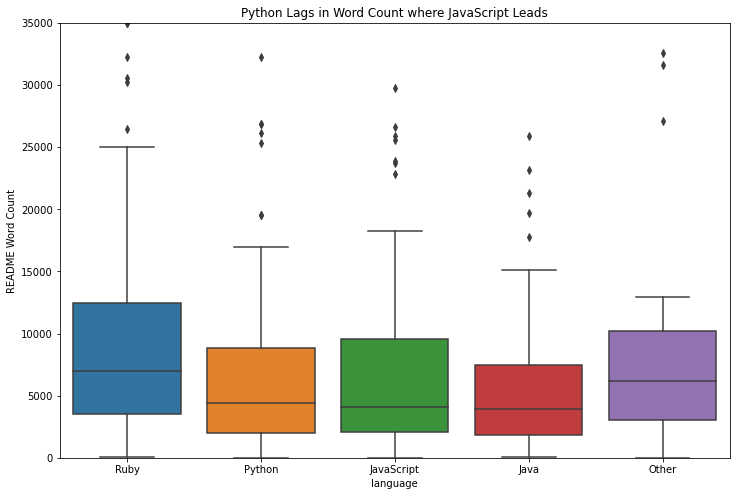

In [8]:
# show the visualizations for this question
explore.q1_vis(train)

#### Hypothesis 1:
- Ho2 -> READMEs for Java projects have more or equal number of words on average than the population.
- Ha2 -> READMEs for Java projects have less words on average than the population.

T-Test One-Sample, One-Tail

In [21]:
# show the statistical results for this question
explore.q1_stats(train)

Reject the Null Hypothesis. 
    
Findings suggest Java projects use less words on average in their READMEs
than projects in other languages.


#### Question 1 Takeaways:
- Java READMEs use less words on average than the population
- Ruby has the widest spread of word count
- Other languages have the smallest spread of word count, and Java has the smallest spread for interquartile range

---
### Question 2: What are the most common words between languages?

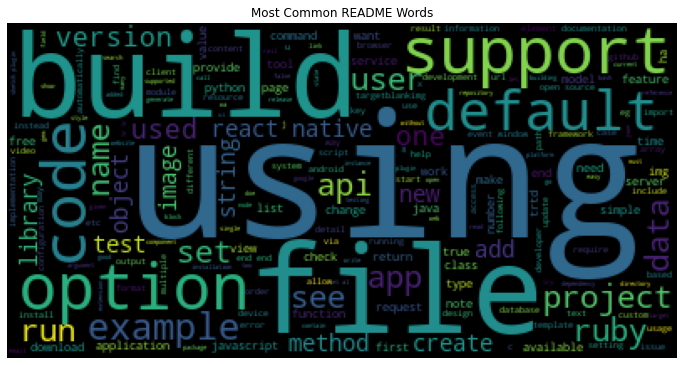

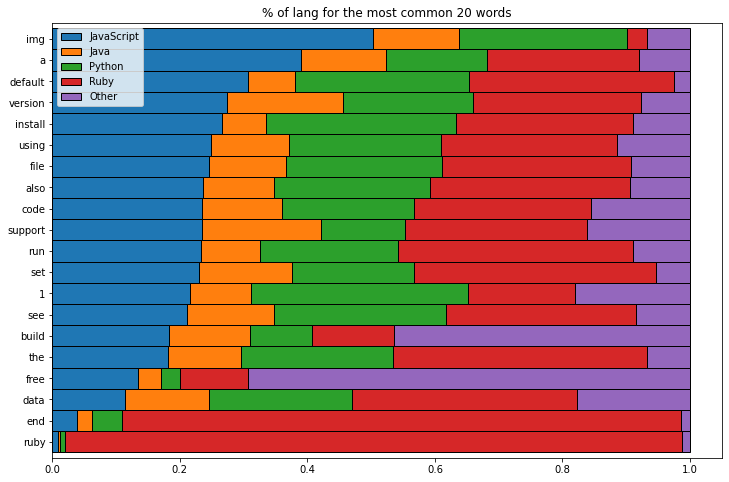

In [10]:
# show the visualizations for this question
explore.q2_vis(all_words, word_counts)

### Question 2b: What about bigrams?

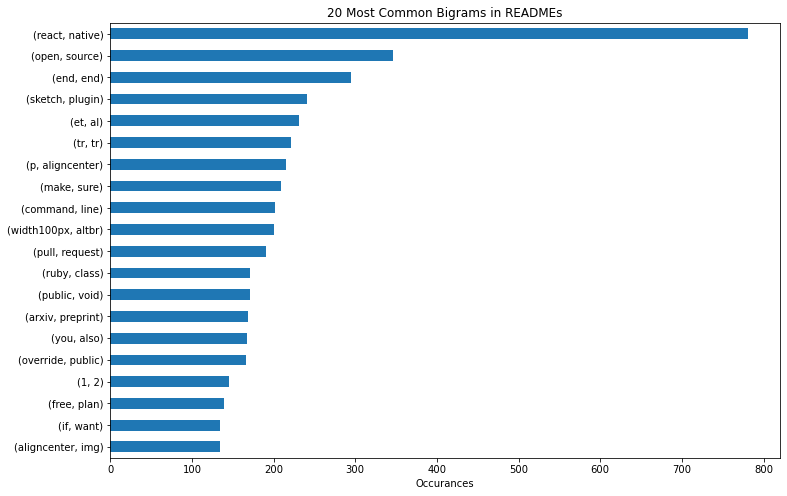

In [16]:
# show the visualizations for this question
explore.q2b_vis(all_words)

#### Question 2 Takeaways:
- Ruby READMEs highly use the word 'ruby' and 'end'
- It makes sense that words that apply to all languages appears across all READMEs

---
### Question 3: How do languages differ in sentiment within their README?

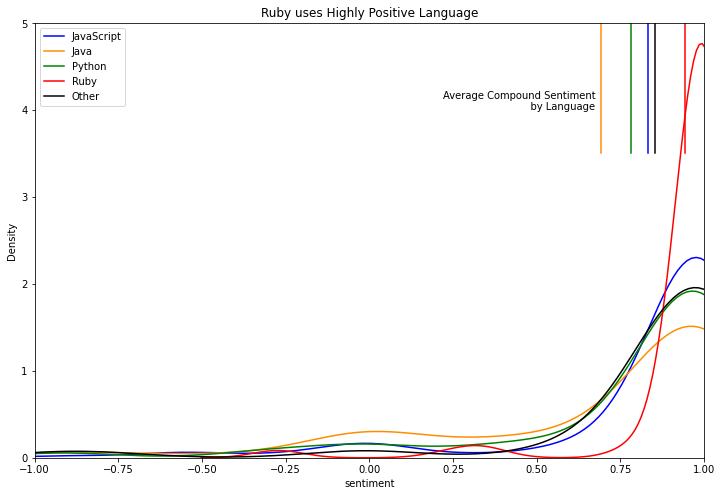

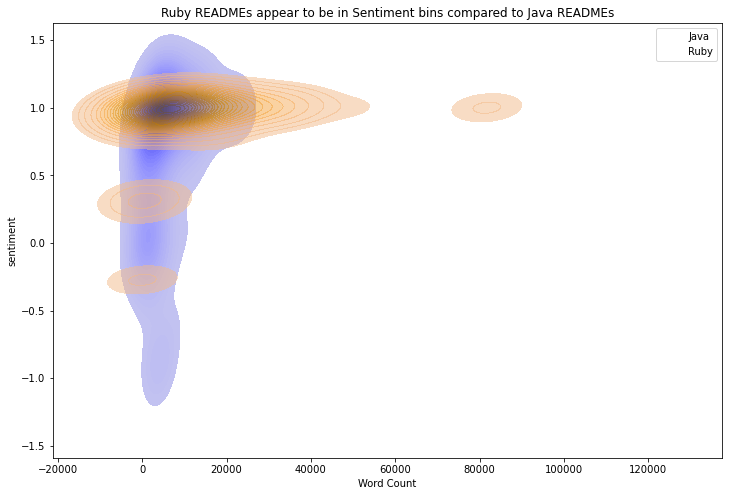

In [17]:
# show the visualizations for this question
explore.q3_vis(train)

#### Hypothesis 3:
- Ho3 -> The average sentiment for Ruby READMEs is equal to or less than the average sentiment for Java READMEs.
- Ha3 -> The average sentiment for Ruby READMEs is higher than the average sentiment for Java READMEs.

T-Test Two-Sample, One-Tail

In [18]:
# show the statistical results for this question
explore.q3_stats(train)

Reject the Null Hypothesis.

Findings suggest the average sentiment for Ruby READMEs is
higher than the average sentiment for Java READMEs


#### Question 3 Takeaways:
- Ruby's average compound sentiment is higher than's Java's
- Ruby's sentiment appears to fall into bins at -.25, .25, and 1 on the sentiment scale where the higher the word count, the more positive the sentiment
- All languages show heavily positive compound sentiment
- A possible explanation is that those that use more words in their README could be the most happy or satisfied with their project

---
### 5. Modeling
#### The goal is to maximize accuracy without overfitting each model.
The cleaned and lemmatized readme content was fit on a Tfid Vectorizer for modeling.
Models ran had various hyperparameters to prevent overfitting and allow repeatable results:
- Decision Tree
    - max_depth = 5
    - random_state = 123
- Random Forest
    - max_depth = 5
    - random_state = 123
- Multinomial Naive Bayes
    - alpha = 1

In [19]:
# run and show the modeling results
model.run_models(train, val)

,train_acc,val_acc
baseline,0.234694,NaN
Decision Tree,0.761905,0.714286
Random Forest,0.831633,0.765306
Naive Bayes,0.906463,0.816327


In [20]:
# run and show the best model results on test
model.run_best(train, val, test)

,Decision Tree
test_acc,0.690355
train_acc,0.761905
val_acc,0.714286


### Modeling Takeaways:
- The Decision Tree model performed the best at 69% accuracy, significantly out performing baseline at 25%
- All of the models outperformed baseline, but appeared to be more overfit
---

## CONCLUSION
Coding languages often work together on projects and support various functions between each other. By using the GitHub README files, we were able to predict the primary language of the project with 69% accuracy. 

#### Recommendations:
- Explore within a single coding language and look at what is in READMEs across various human languages. This may provide insight into how different regional coders use that coding language
- Continue research into why shorter READMEs tend to produce a more negative compound sentiment

#### Next Steps:
- Gather a larger pool of repositories to run the model on. More data will create more clear trends from language to language.
- Clean README data further to remove extraneous words or syntax such as markdown notation or long urls
---